# Evaluation Metrics for Classification

In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np   

import matplotlib.pyplot as plt  
import seaborn as sns            

# Import specific modules from scikit-learn (a machine learning library)
# from sklearn.preprocessing import LabelEncoder  # Uncomment this line if needed
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.metrics import roc_auc_score  # For calculating the ROC AUC score
from sklearn.metrics import roc_curve      # For plotting ROC curves

from sklearn.feature_extraction import DictVectorizer  # For converting dictionaries to feature matrices
from sklearn.linear_model import LogisticRegression   # For training logistic regression models
from sklearn.model_selection import KFold              # For k-fold cross-validation

# Enable inline plotting for Jupyter Notebook or IPython
%matplotlib inline


In [2]:
# loading the dataset
df = pd.read_csv('car-price_data.csv')

## Data Preparation

In [3]:
selected_columns = ['Make', 
                    'Model',
                    'Year',
                    'Engine HP',
                    'Engine Cylinders',
                    'Transmission Type',
                    'Vehicle Style',
                    'highway MPG',
                    'city mpg',
                    'MSRP']

df = df[selected_columns]

df.columns = df.columns.str.lower().str.replace(' ', '_')

strings = list(df.dtypes[df.dtypes == 'object'].index)

for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    

In [4]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500


In [5]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
# Fill in the missing values of the selected features with 0.
df.fillna(0, inplace=True)

df.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [7]:
# Rename MSRP variable to price
df.rename(columns = {'msrp': 'price'}, inplace=True)
df.head(1)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135


In [8]:
df_class = df.copy()

# turn the price variable from numeric into a binary format.
#  create a variable above_average which is 1 if the price is above its mean value and 0 otherwise.

# Calculate the mean price
mean_price = df_class['price'].mean()

# Create the 'above_average' binary variable
df_class['above_average'] = (df_class['price'] > mean_price).astype(int)

# drop price column
df_class = df_class.drop('price', axis = 1)

# Display the updated DataFrame
df_class.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


## Setting up the validation framework
Perform the train/validation/test split with Scikit-Learn

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into train (60%), validation (20%), and test (20%) sets
df_train_full, df_test = train_test_split(df_class, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)  # 20/80 = 0.25


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# Display the shapes of the resulting sets
print("Train set:", df_train.shape, y_train.shape)
print("Validation set:", df_val.shape, y_val.shape)
print("Test set:", df_test.shape, y_test.shape)

Train set: (7148, 10) (7148,)
Validation set: (2383, 10) (2383,)
Test set: (2383, 10) (2383,)


In [10]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [11]:
df_class.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
above_average          int32
dtype: object

In [12]:
numerical_vars = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical_vars = ['make', 'model', 'transmission_type', 'vehicle_style']

In [13]:
# calculating the ROC AUC score

# Create an empty DataFrame to store the ROC AUC scores for each numerical variable
roc_auc_scores = pd.DataFrame(columns=['Variable', 'ROC_AUC'])

# Loop through each numerical variable
for col in numerical_vars:
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_train, df_train[col])
    
    # Check if the ROC AUC score is less than 0.5
    if roc_auc < 0.5:
        # Invert the variable by adding a "-" sign
        roc_auc = roc_auc_score(y_train, -df_train[col])
        
        # Store the ROC AUC score for the variable
    roc_auc_scores = roc_auc_scores.append({'Variable': col, 'ROC_AUC': roc_auc}, ignore_index=True);

# Display the DataFrame with ROC AUC scores for each numerical variable

roc_auc_scores

C:\Users\DELL\AppData\Local\Temp\ipykernel_8768\824532518.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roc_auc_scores = roc_auc_scores.append({'Variable': col, 'ROC_AUC': roc_auc}, ignore_index=True);
C:\Users\DELL\AppData\Local\Temp\ipykernel_8768\824532518.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roc_auc_scores = roc_auc_scores.append({'Variable': col, 'ROC_AUC': roc_auc}, ignore_index=True);
C:\Users\DELL\AppData\Local\Temp\ipykernel_8768\824532518.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roc_auc_scores = roc_auc_scores.append({'Variable': col, 'ROC_AUC': roc_auc}, ignore_index=True);
C:\Users\DELL\AppData\Local\Temp\ipykernel_8768\824532518.py:18: FutureWarning: The frame.append method is

,Variable,ROC_AUC
0,year,0.687551
1,engine_hp,0.917103
2,engine_cylinders,0.766116
3,highway_mpg,0.633059
4,city_mpg,0.673424


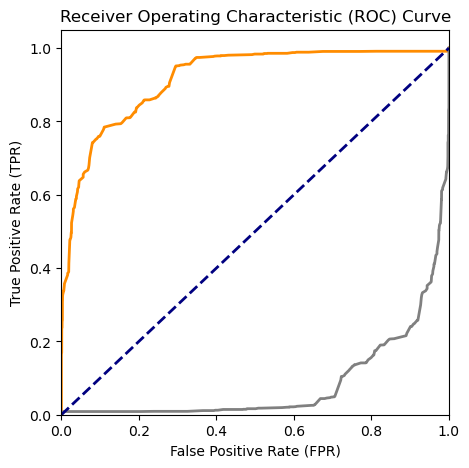

In [16]:
# Plot the ROC curve
plt.figure(figsize=(5, 5))

fpr, tpr, thresholds = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

fpr, tpr, thresholds = roc_curve(y_train, -df_train.engine_hp)
plt.plot(fpr, tpr, color='grey', lw=2, label=f'- ROC curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.show()

## TRAINING THE MODEL

In [17]:
columns = categorical_vars + numerical_vars

# Use DictVectorizer to perform one-hot encoding
train_dicts = df_train[columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# Train a logistic regression model with the specified parameters
logistic_regression_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Evaluate the model
y_pred_prob = logistic_regression_model.predict_proba(X_val)[:, 1]

# Inspecting ROC AUC Score
roc_auc_score(y_val, y_pred_prob)

0.9761329930330412

In [18]:
y_pred_hard = logistic_regression_model.predict(X_val)
roc_auc_score(y_val, y_pred_hard)

0.9134294805468152

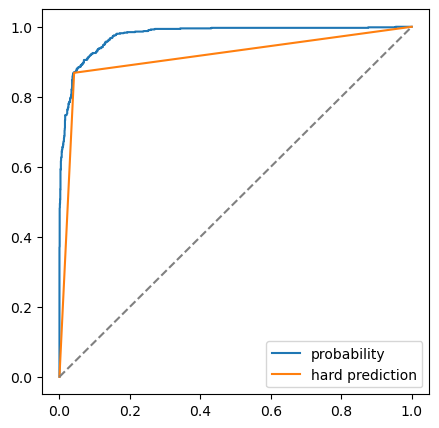

In [19]:
# Set the figure size for the plot to 5x5 inches
plt.figure(figsize=(5, 5))

# Calculate the ROC curve for predictions based on probability scores (y_pred_prob)
fpr, tpr, threshold = roc_curve(y_val, y_pred_prob)

# Plot the ROC curve for probability-based predictions and label it as 'probability' in the legend
plt.plot(fpr, tpr, label='probability')

# Calculate the ROC curve for predictions based on hard binary predictions (y_pred_bin)
fpr, tpr, threshold = roc_curve(y_val, y_pred_hard)

# Plot the ROC curve for hard binary predictions and label it as 'hard prediction' in the legend
plt.plot(fpr, tpr, label='hard prediction')

# Plot a diagonal dashed line representing the ROC curve of a random classifier (no discrimination ability)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Add a legend to the plot to distinguish between 'probability' and 'hard prediction' curves
plt.legend()

# Display the ROC curve plot
plt.show()


In [20]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []
    
    # Create an array of thresholds from 0.0 to 1.0 with a step of 0.01
    thresholds = np.arange(0.0, 1.01, 0.01)

    # Loop through each threshold
    for threshold in thresholds:
        # Classify predictions as positive or negative based on the threshold
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= threshold)
        predict_negative = (y_pred < threshold)

        # Calculate true positives, true negatives,  false positives, and false negatives
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((threshold, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


df_scores = confusion_matrix_dataframe(y_val, y_pred_prob)

# Compute precision and recall for the current threshold
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,644,358,10,1371,0.642715,0.984709
20,0.2,625,226,29,1503,0.734430,0.955657
30,0.3,603,156,51,1573,0.794466,0.922018
40,0.4,585,112,69,1617,0.839311,0.894495
50,0.5,568,72,86,1657,0.887500,0.868502
60,0.6,518,52,136,1677,0.908772,0.792049
70,0.7,489,29,165,1700,0.944015,0.747706
80,0.8,427,14,227,1715,0.968254,0.652905
90,0.9,349,4,305,1725,0.988669,0.533639


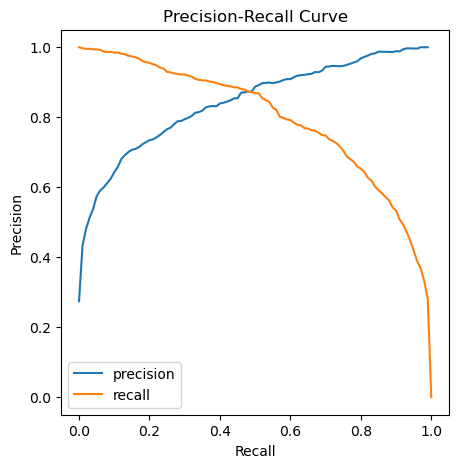

In [21]:
# Plot precision-recall curve
plt.figure(figsize=(5, 5))

plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

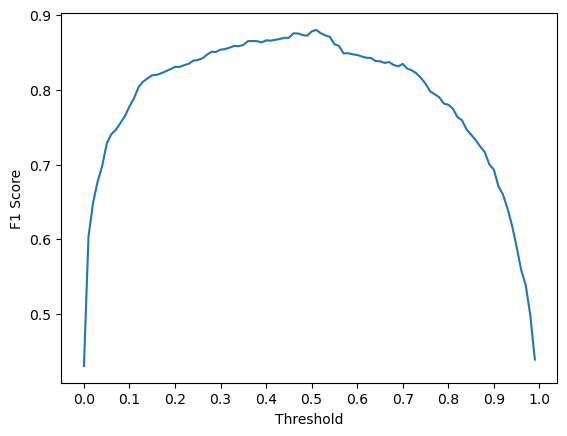

In [22]:
 # Compute F1 score using the precision and recall
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

#Plotting F1 Score:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()
     


In [23]:
# Defining train and predict function
#@ DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.003


In [25]:

# Define the number of splits for k-fold cross-validation
n_splits = 5

# Initialize a k-fold cross-validation object
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

# Iterate over a list of values for the hyperparameter 'C'
for C in [0.01, 0.1, 0.5, 10]:
    # Create an empty list to store ROC AUC scores for each fold
    scores = []

    # Loop through the folds in the cross-validation
    for train_idx, val_idx in kfold.split(df_train_full):

        # Split the dataset into training and validation sets
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        # Extract the target variable (churn) for training and validation
        y_train = df_train.above_average
        y_val = df_val.above_average

        # Train a model using the training data and the specified hyperparameter 'C'
        dv, model = train(df_train, y_train, C=C)

        # Make predictions on the validation data using the trained model
        y_pred = predict(df_val, dv, model)

        # Calculate the ROC AUC score for the validation predictions
        auc = roc_auc_score(y_val, y_pred)

        # Append the ROC AUC score to the list of scores
        scores.append(auc)

        # Print the mean and standard deviation of the ROC AUC scores for the current 'C' value
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.980 +- 0.003
C=10 0.982 +- 0.003
